In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoost, Pool, MetricVisualizer
from copy import deepcopy
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import KFold, train_test_split
import shap

In [2]:
def plot_column_count(df, column_name):
    data = df[column_name].value_counts()

    fig, ax = plt.subplots()
    ax.scatter(data.index, data, s = 7)
    ax.set_xlabel(column_name)
    ax.set_ylabel('Amount')
    fig.set_figwidth(7)
    fig.set_figheight(4)
    plt.show()

In [3]:
members = pd.read_csv('data/members.csv', parse_dates=['registration_init_time', 'expiration_date'])
songs = pd.read_csv('data/songs.csv')
song_extra_info = pd.read_csv('data/song_extra_info.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

In [4]:
len(test)

2556790

In [5]:
members.dtypes

msno                              object
city                               int64
bd                                 int64
gender                            object
registered_via                     int64
registration_init_time    datetime64[ns]
expiration_date           datetime64[ns]
dtype: object

### Preprocessing

In [6]:
train.isnull().sum() * 100 / len(train)

msno                  0.000000
song_id               0.000000
source_system_tab     0.336825
source_screen_name    5.622618
source_type           0.291959
target                0.000000
dtype: float64

In [7]:
train['source_system_tab'] =  train['source_system_tab'].fillna(train['source_system_tab'].value_counts().index[0])
train['source_screen_name'] =  train['source_screen_name'].fillna(train['source_screen_name'].value_counts().index[0])
train['source_type'] =  train['source_type'].fillna(train['source_type'].value_counts().index[0])

In [8]:
test.isnull().sum() * 100 / len(test)

id                    0.000000
msno                  0.000000
song_id               0.000000
source_system_tab     0.330180
source_screen_name    6.370605
source_type           0.285397
dtype: float64

In [9]:
test['source_system_tab'] =  test['source_system_tab'].fillna(test['source_system_tab'].value_counts().index[0])
test['source_screen_name'] =  test['source_screen_name'].fillna(test['source_screen_name'].value_counts().index[0])
test['source_type'] =  test['source_type'].fillna(test['source_type'].value_counts().index[0])

In [10]:
members['day_of_registration'] = (members['registration_init_time'] - pd.to_datetime('1-1-2000')).dt.days
members['day_of_expiration'] = (members['expiration_date'] - pd.to_datetime('1-1-2000')).dt.days
members['subscription_length'] = members['day_of_expiration'] - members['day_of_registration']

del members['day_of_expiration']
del members['day_of_registration']

members = members.drop(['registration_init_time', 'expiration_date'], axis=1)

#### Не очень информативынй признак- много нулей. Дропаем.

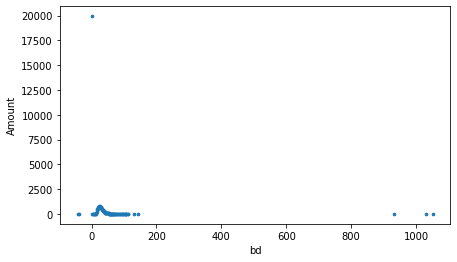

In [11]:
plot_column_count(members, 'bd')

In [12]:
members = members.drop('bd', axis=1)

#### Такая же ситуация с генедером.

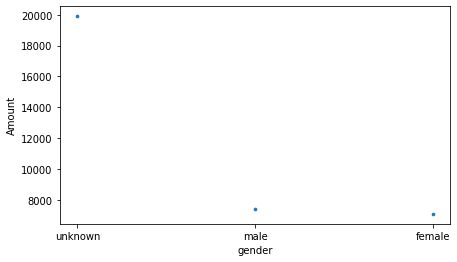

In [13]:
members['gender'] = members['gender'].fillna('unknown')
plot_column_count(members, 'gender')

In [14]:
members = members.drop('gender', axis=1)

#### Мерджим members c train по юзерам.

In [15]:
train_with_members = pd.merge(members, train, on='msno', how='inner')
test_with_members = pd.merge(members, test, on='msno', how='inner')

#### Мерджим songs c их extra фичами по song_id.

In [16]:
merged_extras = pd.merge(songs, song_extra_info, on='song_id', how='inner')

In [17]:
merged_extras.isnull().sum() * 100 / len(merged_extras)

song_id         0.000000
song_length     0.000000
genre_ids       4.098288
artist_name     0.000000
composer       46.655386
lyricist       84.713094
language        0.000044
name            0.000087
isrc            5.947926
dtype: float64

#### Composer и Lyricist имеют много пропусков. Дропаем. Остальное заолняем самыми популярными знаениями.

In [18]:
merged_extras['genre_ids'] = merged_extras['genre_ids'].fillna(merged_extras['genre_ids'].value_counts().index[0])
merged_extras['isrc'] = merged_extras['isrc'].fillna(merged_extras['isrc'].value_counts().index[0])
merged_extras['language'] = merged_extras['language'].fillna(merged_extras['language'].value_counts().index[0])
merged_extras['name'] = merged_extras['name'].fillna(merged_extras['name'].value_counts().index[0])
merged_extras = merged_extras.drop(['lyricist', 'composer'], axis=1)

#### Мерджим все вместе.

In [19]:
merged_train = pd.merge(train_with_members, merged_extras, on='song_id', how='inner')
merged_test = pd.merge(test_with_members, merged_extras, on='song_id', how='left')

In [20]:
merged_train.isnull().sum() * 100 / len(merged_train)

msno                   0.0
city                   0.0
registered_via         0.0
subscription_length    0.0
song_id                0.0
source_system_tab      0.0
source_screen_name     0.0
source_type            0.0
target                 0.0
song_length            0.0
genre_ids              0.0
artist_name            0.0
language               0.0
name                   0.0
isrc                   0.0
dtype: float64

In [21]:
merged_test.isnull().sum() * 100 / len(merged_test)

msno                   0.000000
city                   0.000000
registered_via         0.000000
subscription_length    0.000000
id                     0.000000
song_id                0.000000
source_system_tab      0.000000
source_screen_name     0.000000
source_type            0.000000
song_length            0.031133
genre_ids              0.031133
artist_name            0.031133
language               0.031133
name                   0.031133
isrc                   0.031133
dtype: float64

In [22]:
merged_test['song_length'] = merged_test['song_length'].fillna(np.mean(merged_test['song_length']))
merged_test['genre_ids'] = merged_test['genre_ids'].fillna(merged_test['genre_ids'].value_counts().index[0])
merged_test['language'] = merged_test['language'].fillna(merged_test['language'].value_counts().index[0])
merged_test['isrc'] = merged_test['isrc'].fillna(merged_test['isrc'].value_counts().index[0])
merged_test['name'] = merged_test['name'].fillna(merged_test['name'].value_counts().index[0])
merged_test['artist_name'] = merged_test['artist_name'].fillna(merged_test['artist_name'].value_counts().index[0])

In [23]:
merged_train = merged_train.dropna()

### В некоторых записях жанры встречаются в виде genre_1|genre_2|...
#### Выберем для каждой записи самый популярный жанр среди предложенных.

In [24]:
def split_genres(df):
    c = Counter()
    for row in df['genre_ids']:
        for elem in row.split('|'):
            c[elem] += 1
    return c

def recount_genres(df, values):
    df['genre_ids'] = df['genre_ids'].apply(lambda row: list(sorted(row.split('|'), 
                                                                key=lambda x: values[x], 
                                                                reverse=True))[0])
    return df

In [25]:
train_genres = split_genres(merged_train)
test_genres = split_genres(merged_test)

In [26]:
merged_train = recount_genres(merged_train, train_genres)
merged_test = recount_genres(merged_test, test_genres)

#### ISRC содержит в себе полезную инфу - достанем все необходимое.

In [27]:
def decode_isrc(df):
    df['country_code'] = df['isrc'].apply(lambda row: row[0:2])
    df['reg_organisation'] = df['isrc'].apply(lambda row: row[2:5])
    df['song_registration_year'] = df['isrc'].apply(lambda row: row[5:7])
    df = df.drop('isrc', axis=1)
    return df

In [197]:
train = decode_isrc(merged_train)
test = decode_isrc(merged_test)

In [29]:
def change_types(df):
    df['song_id'] = df['song_id'].astype('category')
    df['city'] = df['city'].astype('uint32')
    df['subscription_length'] = df['subscription_length'].astype('uint32')
    df['registered_via'] = df['registered_via'].astype('category')
    df['song_length'] = df['song_length'].astype('uint32')
    df['genre_ids'] = df['genre_ids'].astype('category')
    df['language'] = (df['language'].astype(int) + 1).astype('category')
    df['song_registration_year'] = df['song_registration_year'].astype('category')
    df['source_system_tab'] = df['source_system_tab'].astype('category')
    df['source_screen_name'] = df['source_screen_name'].astype('category')
    df['source_type'] = df['source_type'].astype('category')
    df['country_code'] = df['country_code'].astype('category')
    df['reg_organisation'] = df['reg_organisation'].astype('category')
    df['artist_name'] = df['artist_name'].astype('category')
    df['language_mode'] = (df['language_mode'].astype(int) + 1).astype('category')
    df['genre_ids_mode'] = df['genre_ids_mode'].astype('category')
    df['artist_name_mode'] = df['artist_name_mode'].astype('category')
    return df

In [30]:
def add_features(df):
    commons_all = (df.groupby('msno')[['language', 'genre_ids', 'artist_name']]
               .agg(lambda x: x.mode().iloc[0])).reset_index()
    commons_all.columns = ['msno', 'language_mode', 'genre_ids_mode', 'artist_name_mode']

    user_logs_sizes = df[['msno']].groupby('msno').size().reset_index()
    user_logs_sizes.columns = ['msno', 'cnt']
    
    genres_user_counter = (df[['msno', 'genre_ids']]
                            .value_counts(subset=['msno', 'genre_ids'])
                            .reset_index())
    genres_user_counter.columns = ['msno', 'genre_ids', 'genre_freq']
    
    language_user_counter = (df[['msno', 'language']]
                            .value_counts(subset=['msno', 'language'])
                            .reset_index())
    language_user_counter.columns = ['msno', 'language', 'language_freq']

    genre_freqs = pd.merge(genres_user_counter, user_logs_sizes, on='msno', how='inner')
    genre_freqs['genre_freq'] /= genre_freqs['cnt']
    genre_freqs = genre_freqs[['msno', 'genre_ids', 'genre_freq']]
    
    lang_freqs = pd.merge(language_user_counter, user_logs_sizes, on='msno', how='inner')
    lang_freqs['language_freq'] /= lang_freqs['cnt']
    lang_freqs = lang_freqs[['msno', 'language', 'language_freq']]
    
    df = pd.merge(df, genre_freqs, on=['msno', 'genre_ids'], how='inner')
    df = pd.merge(df, lang_freqs, on=['msno', 'language'], how='inner')
    df = pd.merge(df, commons_all, on='msno', how='inner')
    
    return df

#### Добавим как фичи популярные жанры, артисты, языки песен у юзеров + посчитает для каждого юзера то, на сколько часто он слушает песни с тем или иным жанром/языком. (+ дропнем юезров, тк возникает сильно переобучение под них).

In [198]:
train = add_features(train).drop(['name'], axis=1)
test = add_features(test).drop(['name'], axis=1)

In [199]:
train = change_types(train)
test = change_types(test)

In [33]:
X = train.drop(['target', 'msno'], axis=1)
y = train['target']

In [34]:
# groups = [[], [], [], [], [], []]

# for i, user in enumerate(X['msno'].unique()):
#     groups[hash(str(user)) % 6].append(user)

In [45]:
default_parameters = {
    'iterations': 200,
    'custom_metric': ['AUC'],
    'verbose': True,
    'random_seed': 0,
    'task_type' : 'CPU',
    'loss_function' : 'Logloss',
    'train_dir' : 'Logloss',
    'eval_metric' : 'AUC'
}

In [46]:
def find_params(X, y):
    grid = {'learning_rate': [0.5, 0.1, 1e-3, 1e-5],
            'l2_leaf_reg': [1, 5, 15],
            'iterations' : [200]}
    
    model = CatBoost()
    
    pool = Pool(data=X, label=y, cat_features=X.dtypes[X.dtypes == 'category'].index.to_list())
    
    grid_search_result = model.grid_search(grid, 
                                       X=pool,
                                       cv=5,
                                       plot=True)
    
    return grid_search_result

In [251]:
from copy import deepcopy
def k_fold_fitter(X, y, k=5, params=None,):
    kf   = KFold(n_splits=k, shuffle=True)
    
    models = []
    aucs = []
    
    i = 0
    for train_index, test_index in kf.split(X):
        print('Done {} / {}'.format(i + 1, k))
        
        cat_params = deepcopy(default_parameters)
        if params is not None:
            cat_params = cat_params | params
        model = CatBoost(cat_params)
        
        X_train, X_validate, y_train, y_validate = train_test_split(X.iloc[train_index], y.iloc[train_index], test_size=0.2)
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        test_pool = Pool(data=X_validate, label=y_validate, cat_features=X_validate.dtypes[X_validate.dtypes == 'category'].index.to_list())
        
        model.fit(X_train, 
                  y_train,
                  eval_set=test_pool,
                  metric_period=50,
                  cat_features=X_train.dtypes[X_train.dtypes == 'category'].index.to_list(),
                  verbose=True
                 )
        
        aucs.append(metrics.roc_auc_score(y_test, model.predict(X_test, prediction_type='Class')))
        models.append(model)
        i +=1
    
    return models, aucs

In [48]:
# grid_result = find_params(X, y)

In [49]:
# grid_result['params']

In [52]:
grid_result = {}
grid_result['params'] = {'l2_leaf_reg': 15, 'iterations': 200, 'learning_rate': 0.5}

In [53]:
models, aucs = k_fold_fitter(X, y, k=5, params=grid_result['params'])

Done 1 / 5
0:	test: 0.6908344	best: 0.6908344 (0)	total: 12.5s	remaining: 41m 20s
50:	test: 0.7624944	best: 0.7624944 (50)	total: 6m 29s	remaining: 18m 58s
100:	test: 0.7702395	best: 0.7702395 (100)	total: 12m 2s	remaining: 11m 48s
150:	test: 0.7754430	best: 0.7754430 (150)	total: 17m 22s	remaining: 5m 38s
199:	test: 0.7785098	best: 0.7785098 (199)	total: 22m 48s	remaining: 0us

bestTest = 0.7785098073
bestIteration = 199

Done 2 / 5
0:	test: 0.6907914	best: 0.6907914 (0)	total: 8.27s	remaining: 27m 26s
50:	test: 0.7610241	best: 0.7610241 (50)	total: 6m 21s	remaining: 18m 34s
100:	test: 0.7690031	best: 0.7690031 (100)	total: 12m 3s	remaining: 11m 49s
150:	test: 0.7744436	best: 0.7744436 (150)	total: 17m 40s	remaining: 5m 44s
199:	test: 0.7777916	best: 0.7777916 (199)	total: 23m 3s	remaining: 0us

bestTest = 0.7777915938
bestIteration = 199

Done 3 / 5
0:	test: 0.6916683	best: 0.6916683 (0)	total: 7.66s	remaining: 25m 25s
50:	test: 0.7599952	best: 0.7599952 (50)	total: 5m 53s	remaining:

### Средний AUC на тестовых множествах

In [54]:
np.mean(aucs)

0.7053690624757828

In [55]:
print(metrics.classification_report(y, models[np.argmax(aucs)].predict(X, prediction_type='Class')))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71   3661799
           1       0.70      0.78      0.74   3714050

    accuracy                           0.72   7375849
   macro avg       0.73      0.72      0.72   7375849
weighted avg       0.73      0.72      0.72   7375849



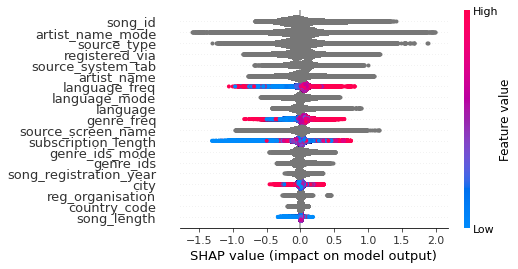

In [56]:
shap_values = shap.TreeExplainer(models[np.argmax(aucs)]).shap_values(X)
shap.summary_plot(shap_values, X, max_display=25, plot_size=None)

In [57]:
# kaggle_dataset = test.drop('id', axis=1)
# ids = test['id']
# answers = np.array(models[np.argmax(aucs)].predict(kaggle_dataset, prediction_type='Probability'))[:, 1]
# result = pd.DataFrame({'id' : ids, 'target' : answers})

# result.to_csv('./kaggle.csv', index=False)

## Неклассические эмбединги

In [58]:
from gensim.models import Word2Vec

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7375849 entries, 0 to 7375848
Data columns (total 21 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   msno                    object  
 1   city                    uint32  
 2   registered_via          category
 3   subscription_length     uint32  
 4   song_id                 category
 5   source_system_tab       category
 6   source_screen_name      category
 7   source_type             category
 8   target                  int64   
 9   song_length             uint32  
 10  genre_ids               category
 11  artist_name             category
 12  language                category
 13  country_code            category
 14  reg_organisation        category
 15  song_registration_year  category
 16  genre_freq              float64 
 17  language_freq           float64 
 18  language_mode           category
 19  genre_ids_mode          category
 20  artist_name_mode        category
dtypes: categ

#### Соберем по юзерам в одну группу те песни, которые имеют таргет 1

In [60]:
songs_features = train[['msno', 'target', 'song_id', 'song_length', 'genre_ids', 'language', 'country_code', 'reg_organisation', 'song_registration_year']].copy()

In [89]:
user_to_liked_songs = songs_features[songs_features['target'] == 1].groupby('msno')['song_id'].apply(list)

In [90]:
w2v_data = user_to_liked_songs.to_list()

#### Обучим W2V

In [113]:
model = Word2Vec(w2v_data, iter=5, min_count=20, window=20)

#### Посмотрим top 10 симиларов для песни под номером 0 из 0 группы

In [114]:
result = np.array(model.wv.most_similar(positive=w2v_data[0][0], topn=10))

In [115]:
songs_info = songs_features.drop(['msno', 'target'], axis=1).drop_duplicates('song_id')

#### Top 10

In [126]:
songs_info[songs_info['song_id'].isin(result[:, 0])]

,song_id,song_length,genre_ids,language,country_code,reg_organisation,song_registration_year
32,vSN/XdTQtflzXi9e/JhSTr7zLppfLExJQM5zd53pt/o=,249986,465,4,HK,I11,10
38,VdVi5NKMJeRDsz4+3xvrpu66FNVTcQ4G26TXoUxW8bU=,256261,465,4,TW,A53,09
49,jFUlstiDM/0JBpQz1N1Mr1uJj0H8kiQsJjfbnx45gHs=,274285,465,4,TW,D95,15
52,+Sm75wnBf/sjm/QMUAFx8N+Ae04kWCXGlgH50tTeM6c=,271255,465,4,TW,A45,16
53,k+ybPqohmGJbKnPkzygHMStRDB6zBfmthlocn1khV1Q=,293477,465,4,HK,F66,98
94,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,320470,465,4,TW,B67,10
112,OtqgQ+4mkx8W1JApMaEVkcnTZW5DYV3WmXWuXB8dmeI=,277849,465,4,HK,D45,02
117,KxxFN09YQwSN0eAJSUf2xa5ZKjyZmX3nIVKM+zKxq6Q=,275644,465,4,TW,K23,13
139,GFWjz4apE8zMiXe6wc0qCjr+DbK9BFkwo/rr+FsNm+g=,282070,465,4,GB,PS8,15
145,l71bGvOgjZIJQHa+E1GW7L5QWYSliCUKy+Hg3SmxzOE=,261328,465,4,TW,A53,14


#### Трек, для которого выведены симилары

In [127]:
songs_info[songs_info['song_id'] == w2v_data[0][0]]

,song_id,song_length,genre_ids,language,country_code,reg_organisation,song_registration_year
39,35dx60z4m4+Lg+qIS0l2A8vspbthqnpTylWUu51jW+4=,275017,465,4,TW,D97,15


#### Видно, что в топе симиларов песни с таким же жанром/языком/country_code

## Построим рекомендательную систему на основе W2V

#### Будем считать user_vector как средний вектор песен, которые юзеру понравились (и которые есть в словаре). Брать скалярное произведение с песней, которую хотим предсказать.

#### В качестве предложений для w2v возьмем песни, что понравились юзерам (для каждого юзера) + песни одного жанра + песни от одного артиста.

In [283]:
from tqdm import tqdm
from collections import defaultdict

def get_w2v_model(data):
    model = Word2Vec(data, iter=30, min_count=15, window=1000, negative=20)
    return model

def get_w2v_predictions(model, users_info, all_data):
    pred_score = lambda x, y: np.dot(x, y)
    zero_vector = np.array([0] * model.vector_size)
    songs_vectors = defaultdict(lambda: zero_vector)
    
    all_answers = []
    all_predicted = []
    
    for key in model.wv.vocab.keys():
        songs_vectors[key] = model.wv[key]
    for (user_liked_songs, to_predict) in tqdm(users_info):
        if len(user_liked_songs) == 0:
            user_vector = zero_vector
        else:
            songs = user_liked_songs.iloc[0]['song_id']
            songs = list(filter(lambda song: song in model.wv.vocab, songs))
            if len(songs) > 0:
                user_vector = np.mean(model.wv[songs], axis=0)
            else:
                user_vector = zero_vector
        songs = to_predict['song_id'].values.to_list()
        ans = list(map(lambda song: pred_score(user_vector, songs_vectors[song]), songs))
        all_predicted = all_predicted + ans
        all_answers = all_answers + to_predict['answer'].values.tolist()
        

    return all_answers, all_predicted

def get_songs(X, y, liked=False):
    return pd.DataFrame(X[y == int(liked)].groupby('msno')['song_id'].apply(list))

def get_train_data(X, y):
    by_user = X[y == 1].groupby('msno')['song_id'].apply(list)
    by_genre = X[y == 1].groupby('msno')['genre_ids'].apply(list)
    by_artist = X[y == 1].groupby('msno')['artist_name'].apply(list)
    return pd.concat([by_user, by_genre, by_artist])

In [284]:
def k_fold_fitter_w2v(X, y, k=3):
    kf   = KFold(n_splits=k, shuffle=True)
    
    models = []
    aucs = []
    
    i = 0
    for train_index, test_index in kf.split(X):
        print('Done {} / {}'.format(i + 1, k))
        
        X_train, y_train = X.iloc[train_index].copy(), y.iloc[train_index]
        X_test, y_test = X.iloc[test_index].copy(), y.iloc[test_index]
        X_test['answer'] = y_test
        
        model = get_w2v_model(get_train_data(X_train.copy(), y_train))
        
        liked = get_songs(X_train, y_train, liked=True).reset_index()
        
        test_data = []
        
        for user_id, to_predict in X_test.groupby('msno'):
            test_data.append((liked[liked['msno'] == user_id], 
                              to_predict[['song_id', 'answer']].copy()))
            
        
        y_true, y_pred = get_w2v_predictions(model, test_data, X_test)
        
        aucs.append(metrics.roc_auc_score(y_true, y_pred))
        print(aucs[i])
        models.append(model)
        i +=1
    
    return models, aucs

In [285]:
%%time

w2v_models, w2v_aucs = k_fold_fitter_w2v(train.drop('target', axis=1), train['target'])

Done 1 / 3


100%|██████████| 29469/29469 [11:34<00:00, 42.41it/s]


0.607108086220153
Done 2 / 3


100%|██████████| 29475/29475 [10:58<00:00, 44.78it/s]


0.6063942035116824
Done 3 / 3


100%|██████████| 29483/29483 [11:20<00:00, 43.34it/s]


0.6070556751558804
CPU times: user 2h 21min 30s, sys: 5min 11s, total: 2h 26min 42s
Wall time: 1h 16min 44s


#### Получили вот такой результат.

In [286]:
np.mean(w2v_aucs)

0.606852654962572

## Теперь попробуем использовать предсказания w2v в качестве фичей для gbdt.

In [287]:
model = get_w2v_model(get_train_data(train.copy(), train['target']))

In [288]:
liked = get_songs(train, train['target'], liked=True).reset_index()
        
user_wise_split = []
users = {}
        
for user_id, to_predict in train.groupby('msno'):
    users[user_id] = to_predict[['song_id', 'target']]
    user_wise_split.append((liked[liked['msno'] == user_id], 
                      to_predict[['song_id', 'target']].rename(columns={'target' : 'answer'})))

In [289]:
y_true, y_pred = get_w2v_predictions(model, user_wise_split, train)

100%|██████████| 30755/30755 [39:12<00:00, 13.07it/s]


In [290]:
shift = 0

user_column = []
song_column = []
predicted_column = []

for user in tqdm(users.keys()):
    users[user].loc[:, 'w2v_predict'] = y_pred[shift:shift + len(users[user])]
    users[user].loc[:, 'msno'] = user
    shift += len(users[user])
    
    user_column = user_column + users[user]['msno'].to_list()
    song_column = song_column + users[user]['song_id'].to_list()
    predicted_column = predicted_column + users[user]['w2v_predict'].to_list()

100%|█████████▉| 30754/30755 [1:36:20<00:00,  2.82it/s]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 30755/30755 [1:36:21<00:00,  5.32it/s]


In [291]:
w2v_train = pd.DataFrame({'msno' : user_column, 'song_id' : song_column, 'w2v_prediction' : predicted_column})

In [292]:
X_w2v = pd.merge(train, w2v_train, on=['msno', 'song_id'], how='inner')

In [293]:
X_w2v['song_id'] = X_w2v['song_id'].astype('category')
X_w2v['city'] = X_w2v['city'].astype('category')

In [294]:
y_w2v = X_w2v['target']
X_w2v = X_w2v.drop(['target', 'msno'], axis=1)

In [295]:
w2v_models, w2v_aucs = k_fold_fitter(X_w2v, y_w2v, k=5, params=grid_result['params'])

Done 1 / 5
0:	test: 0.7170669	best: 0.7170669 (0)	total: 14.1s	remaining: 46m 52s
50:	test: 0.7908679	best: 0.7908679 (50)	total: 8m 14s	remaining: 24m 4s
100:	test: 0.7995854	best: 0.7995854 (100)	total: 16m 30s	remaining: 16m 11s
150:	test: 0.8042856	best: 0.8042856 (150)	total: 23m 42s	remaining: 7m 41s
199:	test: 0.8072223	best: 0.8072223 (199)	total: 31m 34s	remaining: 0us

bestTest = 0.8072223498
bestIteration = 199

Done 2 / 5
0:	test: 0.7168548	best: 0.7168548 (0)	total: 14.5s	remaining: 47m 56s
50:	test: 0.7908496	best: 0.7908496 (50)	total: 7m 57s	remaining: 23m 15s
100:	test: 0.7986304	best: 0.7986304 (100)	total: 15m 58s	remaining: 15m 39s
150:	test: 0.8027477	best: 0.8027477 (150)	total: 23m 54s	remaining: 7m 45s
199:	test: 0.8061269	best: 0.8061269 (199)	total: 31m 31s	remaining: 0us

bestTest = 0.8061269398
bestIteration = 199

Done 3 / 5
0:	test: 0.7175816	best: 0.7175816 (0)	total: 14.5s	remaining: 47m 58s
50:	test: 0.7902708	best: 0.7902708 (50)	total: 7m 26s	remainin

In [296]:
np.mean(w2v_aucs)

0.7278504895800062

In [297]:
print(metrics.classification_report(y, w2v_models[np.argmax(w2v_aucs)].predict(X_w2v, prediction_type='Class')))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74   3661799
           1       0.74      0.78      0.76   3714050

    accuracy                           0.75   7375849
   macro avg       0.75      0.75      0.75   7375849
weighted avg       0.75      0.75      0.75   7375849



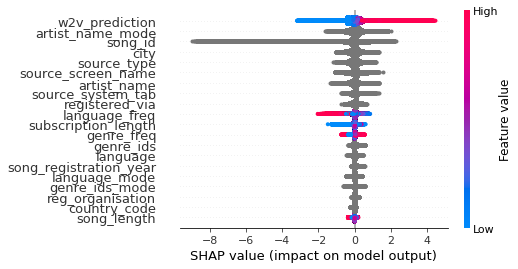

In [298]:
shap_values = shap.TreeExplainer(w2v_models[np.argmax(w2v_aucs)]).shap_values(X_w2v)
shap.summary_plot(shap_values, X_w2v, max_display=25, plot_size=None)

#### Как видим,предсказания от W2V улучшили результат и сама фича стала топ-1 по вкладу в финальный результат модели.